By: Denver Chernin <br>

In [3]:
#Importing necessary libraries
import pandas as p #dataframes to hold tables
from pandasql import sqldf #sql to dataframe conversion for data access
from sklearn.model_selection import train_test_split #method to split dataframe into train and test sets
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
import statistics
import subprocess
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#Lambda function to make sql queries of data frames cleaner
pysqldf = lambda q: sqldf(q, globals())

In [5]:
#Reading in the college data
df_college = p.read_csv('../data/CollegePlaying.csv')

#Reading in the batting data of all players
df_batting = p.read_csv('../data/Batting.csv')

#Reading in the pitching data for all pitchers
df_pitchers = p.read_csv('../data/Pitching.csv')

#Reading in the people data (allows me to translate playerIDs into names (first and last))
df_people = p.read_csv('../data/People.csv')

#Reading in the wOBA (weighted on base average) weights for every year to use in calculations 
#as the linear equations for wOBA stays the same every year, but the weights do not
df_weights = p.read_csv('../data/wOBA_Weights.csv')

In [6]:
#Grabbing the unique playerIDs that exist in the df_college table (AKA obtaining what players played in college)
df_college_playerids = pysqldf("SELECT DISTINCT playerID from df_college where yearID >= 1955 group by playerID")

In [7]:
df_college_playerids.head(5)

,playerID
0,aardsda01
1,abadan01
2,abbotje01
3,abbotji01
4,abbotky01


In [8]:
#Grabbing all of the batting statistics for each player that went to college
df_batters_college = pysqldf("SELECT * FROM df_batting WHERE df_batting.playerID IN (SELECT * FROM df_college_playerids) and G >= 50 and AB > 0")

In [9]:
df_batters_college.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,kindaje01,1957,1,CHN,NL,72,181,18,29,3,...,12.0,1.0,0.0,8,48.0,0.0,0.0,3.0,0.0,4.0
1,altmage01,1959,1,CHN,NL,135,420,54,103,14,...,47.0,1.0,0.0,34,80.0,4.0,7.0,6.0,1.0,8.0
2,cashno01,1959,1,CHA,AL,58,104,16,25,0,...,16.0,1.0,1.0,18,9.0,3.0,5.0,1.0,2.0,0.0
3,fairlro01,1959,1,LAN,NL,118,244,27,58,12,...,23.0,0.0,4.0,31,29.0,2.0,1.0,6.0,2.0,3.0
4,hadleke01,1959,1,KC1,AL,113,288,40,73,11,...,39.0,1.0,2.0,24,74.0,0.0,1.0,2.0,3.0,6.0


In [10]:
#Grabbing all of the batting statistics for each player that DIDNT go to college
df_batters_no_college = pysqldf("SELECT * FROM df_batting WHERE df_batting.playerID NOT IN (SELECT * FROM df_college_playerids) and G >= 50 and yearID > 1955 and AB > 0")

In [11]:
df_batters_no_college.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aaronha01,1956,1,ML1,NL,153,609,106,200,34,...,92.0,2.0,4.0,37,54.0,6.0,2.0,5.0,7.0,21.0
1,adcocjo01,1956,1,ML1,NL,137,454,76,132,23,...,103.0,1.0,0.0,32,86.0,6.0,1.0,11.0,2.0,11.0
2,amorosa01,1956,1,BRO,NL,114,292,53,76,11,...,58.0,3.0,4.0,59,51.0,6.0,1.0,8.0,1.0,4.0
3,aparilu01,1956,1,CHA,AL,152,533,69,142,19,...,56.0,21.0,4.0,34,63.0,2.0,1.0,14.0,1.0,9.0
4,ashburi01,1956,1,PHI,NL,154,628,94,190,26,...,50.0,10.0,1.0,79,45.0,3.0,5.0,6.0,1.0,4.0


In [12]:
no_college_count = pysqldf("SELECT COUNT(*) as C from df_batters_no_college")
print("Number of games played >= 50, no college: " + str(no_college_count['C'].iloc[0]))

Number of games played >= 50, no college: 14747


In [13]:
college_count = pysqldf("SELECT COUNT(*) as C from df_batters_college where G >= 50")
print("Number of games played >= 50, college: " + str(college_count['C'].iloc[0]))

Number of games played >= 50, college: 9858


In [14]:
df_combined = p.concat([df_batters_college, df_batters_no_college])
df_combined = pysqldf("SELECT * FROM df_combined ORDER BY playerID")
count = pysqldf("SELECT DISTINCT COUNT(*) AS c FROM df_combined")
print("Number of total players: " + str(count['c'].iloc[0]))

Number of total players: 24605


$$OPS  = \frac{AB * (H + BB + HBP) + TB * (AB + BB + SF + HBP}{AB * (AB + BB + SF + HBP)}$$
<br>
$$wOBA = \frac{x*BB + x*HBP + x*1B + x*2B + x*3B + x*HR}{AB + BB - IBB + SF + HBP}$$

In [15]:
def OPS_calc(AB, H, BB, HBP, tb, SF):
    numerator = (AB * (H + BB + HBP)) + (tb * (AB + BB + SF + HBP))
    denominator = AB * (AB + BB + SF + HBP)
    return numerator/denominator

def wOBA_calc(AB, H, BB, DBL, TPL, HR, IBB, HBP, SF, year):
    numerator = (df_weights.iloc[2021 - year]['wBB'] * BB)\
                + (df_weights.iloc[2021 - year]['wHBP'] * HBP)\
                + (df_weights.iloc[2021 - year]['w1B'] * H)\
                + (df_weights.iloc[2021 - year]['w2B'] * DBL)\
                + (df_weights.iloc[2021 - year]['w3B'] * TPL)\
                + (df_weights.iloc[2021 - year]['wHR'] * HR)
    denominator = AB + BB - IBB + SF + HBP
    return numerator/denominator

In [16]:
def season_averager_and_add_college_flag_and_tb(lst_rows):
    #Take each column that will be used in wOBA and OPS and average them over the rows
        #Columns needed for wOBA = uBB (labeled BB in dataset), HBP, 1B (labeled H in dataset), 2B, 3B, HR, AB, IBB, SF, HBP
        #Columns needed for OPS = H, BB, HBP, AB, SF, TB (total bases = 1*H + 2*2B + 3*3B + 4*HR)

    #Input: list of rows for one playerID
    #Output: a row with averaged statistics for that playerID along with a 2 new columns: one which is college flag indicating whether
    #or not that playerID has gone to college, the other is the total bases for that player
    ret = []
    ret.append(lst_rows[0][0]) # maintaing the playerID
    ab = 0
    h = 0
    dbl = 0
    tpl = 0
    hr = 0
    bb = 0
    ibb = 0
    hbp = 0
    sf = 0
    ops = 0
    woba = 0
    for r in lst_rows:
        year, AB, H, DBL, TPL, HR, BB, IBB, HBP, SF = r[1], r[6], r[8], r[9], r[10], r[11], r[15], r[17], r[18], r[20]
        ab += AB
        h += H
        dbl += DBL
        tpl += TPL 
        hr += HR
        bb += BB
        ibb += IBB
        hbp += HBP
        sf += SF
        tb = h + (2*DBL) + (3*TPL) + (4*HR)
        ops += OPS_calc(AB, H, BB, HBP, tb, SF)
        woba += wOBA_calc(AB, H, BB, DBL, TPL, HR, IBB, HBP, SF, year)
    seasons_played = len(lst_rows)
    ret.append(round(ab/seasons_played, 2))
    ret.append(round(h/seasons_played, 2))
    ret.append(round(dbl/seasons_played, 2))
    ret.append(round(tpl/seasons_played, 2))
    ret.append(round(hr/seasons_played, 2))
    ret.append(round(bb/seasons_played, 2))
    ret.append(round(ibb/seasons_played, 2))
    ret.append(round(hbp/seasons_played, 2))
    ret.append(round(sf/seasons_played, 2))
    ret.append(round(ops/seasons_played, 2))
    ret.append(round(woba/seasons_played, 2))
    row_occurrence = df_batters_college[(df_batters_college['playerID'] == ret[0])].index.tolist()
    if(len(row_occurrence) > 0):
        ret.append(1)
    else:
        ret.append(0)
    return ret

In [17]:
curr_playerID = df_combined['playerID'].iloc[0]
lst = []
df_lst = []
for index, row in df_combined.iterrows():
    if(curr_playerID != row[0]):
        ret = season_averager_and_add_college_flag_and_tb(lst)
        df_lst.append(ret)
        lst.clear()
        curr_playerID = row[0]
        lst.append(row)
    else:
        lst.append(row)

In [18]:
df_career_combined = p.DataFrame(df_lst, columns=["playerID", "AB", "H", "2B", "3B", "HR", "BB", "IBB", "HBP", "SF", "OPS", "wOBA", "College"])

In [19]:
df_career_combined.head()

,playerID,AB,H,2B,3B,HR,BB,IBB,HBP,SF,OPS,wOBA,College
0,aaronha01,537.81,164.33,26.67,3.95,34.05,63.10,13.71,1.24,5.38,5.05,0.52,0
1,aaronto01,250.67,57.67,12.00,2.00,3.33,24.33,0.67,0.00,2.00,0.99,0.33,0
2,abbotje01,229.50,63.50,14.50,1.00,7.50,15.00,1.00,1.00,3.00,1.02,0.42,1
3,abbotku01,296.67,75.83,15.83,3.67,9.00,19.67,1.83,2.50,1.50,1.78,0.40,0
4,abercre01,255.00,54.00,12.00,2.00,5.00,18.00,2.00,3.00,1.00,0.68,0.33,1


In [20]:
def add_to_dictionary(d, itemsToInsert):
    for key, value in itemsToInsert.items():
        try:
            d[key].append(value)
        except KeyError as err:
            d[key] = []
            d[key].append(value)
    return d

college = {}
no_college = {}
for index, row in df_career_combined.iterrows():
    AB, H, DBL, TPL, HR, BB, IBB, HBP, SF, ops, woba, college_flag = row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], \
                                                        row[10], row[11], row[12]
    features = {"AB": AB, "H": H, "DBL": DBL, "TPL": TPL, "HR": HR, "BB": BB, "IBB": IBB, "HBP": HBP, "SF": SF, "OPS": ops, "wOBA": woba}
    if college_flag:
        college = add_to_dictionary(college, features)
    else:
        no_college = add_to_dictionary(no_college, features)

In [22]:
college_AB = college["AB"]
no_college_AB = no_college["AB"]
# print(len(college, AB)

Need model (or two) for binary classification (two classes = college or no college) </br>
Choices:</br>
    1) Logistic regression</br>
    2) Naive Bayesian (probably not)</br>
    3) Support Vector Machine</br>
    4) k-Nearest-Neighbors (doesn't really train, just plots data and finds nearest k-neighbors, so probably not or as second model)</br>
    5) Decision tree (probably not - too large!) </br>
    **6) Artificial Neural Network w/ Single layer perception (trying this first)** (https://www.kaggle.com/mirichoi0218/ann-making-model-for-binary-classification)</br>

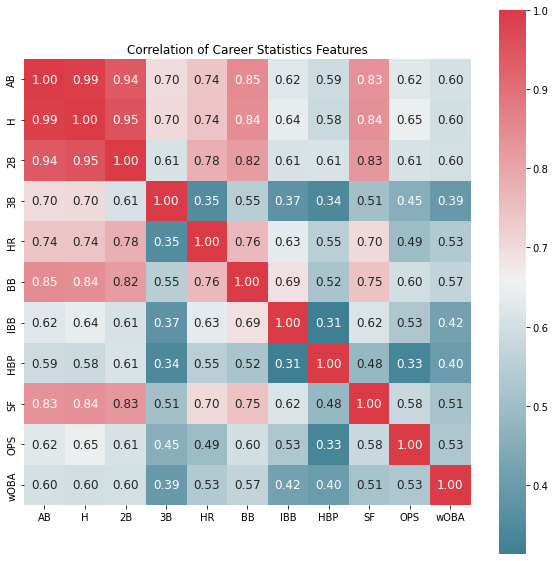

In [19]:
corr = df_career_combined.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 12}, \
            cmap = colormap, linewidths = 0, linecolor = 'white')
plt.title('Correlation of Career Statistics Features')
plt.show()

In [20]:
print("Dataset shape: ", df_career_combined.shape)

Dataset shape:  (4694, 13)


<AxesSubplot:xlabel='College', ylabel='count'>

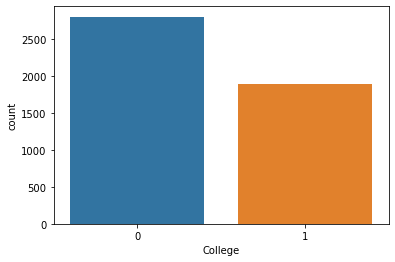

In [21]:
sns.countplot(df_career_combined['College'], label = "Count")

# ANN SLP

In [22]:
train, test = train_test_split(df_career_combined, test_size = 0.3, random_state = 12)
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3285, 13)
Test data shape:  (1409, 13)


In [33]:
train_player_id = train['playerID']
test_player_id = test['playerID']
train_data = train.iloc[:, 1:]
test_data = test.iloc[:, 1:]

print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (3285, 12)
Test data shape:  (1409, 12)


In [29]:
train_x = train_data.iloc[:, :-1]
train_x = MinMaxScaler().fit_transform(train_x)
test_x = test_data.iloc[:, :-1]
test_x = MinMaxScaler().fit_transform(test_x)
print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

Train data shape:  (3285, 11)
Test data shape:  (1409, 11)


In [37]:
train_y = train_data.iloc[:,-1:]
test_y = test_data.iloc[:, -1:]
print("Train_y data shape: ", train_y.shape)
print("Test_y data shape: ", test_y.shape)

Train_y data shape:  (3285, 1)
Test_y data shape:  (1409, 1)


In [38]:
X = tf.placeholder(tf.float32, [None, 11])
Y = tf.placeholder(tf.float32, [None, 1])

In [40]:
W = tf.Variable(tf.random_normal([11,1], seed=0), name = 'weight')
b = tf.Variable(tf.random_normal([1], seed=0), name = 'bias')

In [41]:
logits = tf.matmul(X,W) + b

In [44]:
hypothesis = tf.nn.sigmoid(logits)
cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = Y)
cost = tf.reduce_mean(cost_i)

In [45]:
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

In [46]:
prediction = tf.cast(hypothesis > 0.5, dtype = tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))

In [48]:
print("\n============Processing============")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(10001):
        sess.run(train, feed_dict={X: train_x, Y: train_y})
        if step % 1000 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

    train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})

    print("\n============Results============")
    print("Model Prediction =", train_acc)
    print("Test Prediction =", test_acc)


============Processing============


2021-10-28 14:09:38.778481: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 14:09:38.778868: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Step:     0	Loss: 0.688	Acc: 54.98%
Step:  1000	Loss: 0.672	Acc: 58.75%
Step:  2000	Loss: 0.668	Acc: 59.06%
Step:  3000	Loss: 0.666	Acc: 59.33%
Step:  4000	Loss: 0.664	Acc: 59.45%
Step:  5000	Loss: 0.663	Acc: 59.51%
Step:  6000	Loss: 0.663	Acc: 59.54%
Step:  7000	Loss: 0.662	Acc: 59.57%
Step:  8000	Loss: 0.661	Acc: 59.60%
Step:  9000	Loss: 0.661	Acc: 59.54%
Step: 10000	Loss: 0.661	Acc: 59.54%

============Results============
Model Prediction = 0.5954338
Test Prediction = 0.61391056


# ANN SLP PCA

In [49]:
def ann_slp_pca():
    sklearn_pca = sklearnPCA(n_components=10)
    print("==============DATA SUMMARY==============")
    pca_train_x = sklearn_pca.fit_transform(train_x)
    print("PCA Train shape: ", pca_train_x.shape)
    pca_test_x = sklearn_pca.fit_transform(test_x)
    print("PCA Test shape: ", pca_test_x.shape)
    
    X = tf.placeholder(tf.float32, [None, 10])
    Y = tf.placeholder(tf.float32, [None, 1])
    
    W = tf.Variable(tf.random_normal([10,1], seed=0), name='weight')
    b = tf.Variable(tf.random_normal([1], seed=0), name='bias')
    
    logits = tf.matmul(X,W) + b
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.2).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))
    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: pca_train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: pca_train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: pca_train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: pca_test_x, Y: test_y})
        
        print("\n============Results============")
        print("PCA Model Prediction =", train_acc)
        print("PCA Test Prediction =", test_acc)
        
        return train_acc, test_acc

In [50]:
ann_slp_pca_train_acc, ann_slp_pca_test_acc = ann_slp_pca()

==============DATA SUMMARY==============
PCA Train shape:  (3285, 10)
PCA Test shape:  (1409, 10)

============Processing============
Step:     0	Loss: 0.694	Acc: 56.47%
Step:  1000	Loss: 0.677	Acc: 58.72%
Step:  2000	Loss: 0.670	Acc: 59.03%
Step:  3000	Loss: 0.666	Acc: 59.15%
Step:  4000	Loss: 0.663	Acc: 58.93%
Step:  5000	Loss: 0.662	Acc: 59.15%
Step:  6000	Loss: 0.661	Acc: 59.30%
Step:  7000	Loss: 0.660	Acc: 59.39%
Step:  8000	Loss: 0.659	Acc: 59.60%
Step:  9000	Loss: 0.659	Acc: 59.91%
Step: 10000	Loss: 0.659	Acc: 60.03%

============Results============
PCA Model Prediction = 0.6003044
PCA Test Prediction = 0.5677786


# ANN MLP

In [51]:
def ann_mlp():
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,11])
    Y = tf.placeholder(tf.float32, [None, 1])

    # input
    W1 = tf.Variable(tf.random_normal([11,60], seed=0), name='weight1')
    b1 = tf.Variable(tf.random_normal([60], seed=0), name='bias1')
    layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

    # hidden1
    W2 = tf.Variable(tf.random_normal([60,60], seed=0), name='weight2')
    b2 = tf.Variable(tf.random_normal([60], seed=0), name='bias2')
    layer2 = tf.nn.sigmoid(tf.matmul(layer1,W2) + b2)

    # hidden2
    W3 = tf.Variable(tf.random_normal([60,90], seed=0), name='weight3')
    b3 = tf.Variable(tf.random_normal([90], seed=0), name='bias3')
    layer3 = tf.nn.sigmoid(tf.matmul(layer2,W3) + b3)

    # output
    W4 = tf.Variable(tf.random_normal([90,1], seed=0), name='weight4')
    b4 = tf.Variable(tf.random_normal([1], seed=0), name='bias4')
    logits = tf.matmul(layer3,W4) + b4
    hypothesis = tf.nn.sigmoid(logits)

    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: test_x, Y: test_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc
    
ann_mlp_train_acc, ann_mlp_test_acc = ann_mlp()

===========Data Summary===========
Training Data : (3285, 11)
Testing Data : (1409, 11)

============Processing============
Step:     0	Loss: 1.032	Acc: 59.09%
Step:  1000	Loss: 0.691	Acc: 57.26%
Step:  2000	Loss: 0.682	Acc: 57.72%
Step:  3000	Loss: 0.680	Acc: 58.20%
Step:  4000	Loss: 0.679	Acc: 58.23%
Step:  5000	Loss: 0.677	Acc: 58.45%
Step:  6000	Loss: 0.676	Acc: 58.54%
Step:  7000	Loss: 0.675	Acc: 58.69%
Step:  8000	Loss: 0.674	Acc: 58.75%
Step:  9000	Loss: 0.674	Acc: 58.78%
Step: 10000	Loss: 0.673	Acc: 58.84%

============Results============
Model Prediction = 0.58843225
Test Prediction = 0.5805536


In [56]:
sub = p.DataFrame()
sub['playerID'] = test_player_id
sub['Predict_Type'] = test_predict.astype(int)
sub['Origin_Type'] = test_y
sub['Correct'] = test_correct
sub.head(10)

,playerID,Predict_Type,Origin_Type,Correct
1467,garciad01,0,0,True
3215,paniajo01,0,0,True
2295,klippjo01,0,0,True
4032,speiech01,0,1,False
4688,zipfebu01,0,0,True
2571,mabryjo01,0,1,False
48,aldremi01,0,1,False
456,boteda01,0,0,True
2522,lopezhe01,0,0,True
1370,forstte01,0,0,True


# Support Vector Machine

In [83]:
data = df_career_combined.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(data, df_career_combined['College'], test_size = 0.30, random_state = 12)
X_train = X_train.iloc[:, :-1]
X_test = X_test.iloc[:, :-1]

In [88]:
clf = svm.SVC(kernel='poly', degree = 2)

In [89]:
clf.fit(X_train, y_train)

SVC(degree=2, kernel='poly')

In [90]:
y_pred = clf.predict(X_test)

In [91]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.6132008516678495


In [71]:
stats_college = p.DataFrame.from_dict(college)
sc = stats_college.mean(axis = 0)
stats_no_college = p.DataFrame.from_dict(no_college)
snc = stats_no_college.mean(axis = 0)
stats = p.DataFrame(columns = ["AB", "H", "DBL", "TPL", "HR", "BB", "IBB", "HBP", "SF", "OPS", "wOBA"])
stats = stats.append(sc, ignore_index=True) #ZERO INDEX IS COLLEGE
stats = stats.append(snc, ignore_index=True) #ONE INDEX IS NO COLLEGE
stats.index = ["College Ball", "No College Ball"]
stats.head()

,AB,H,DBL,TPL,HR,BB,IBB,HBP,SF,OPS,wOBA
College Ball,215.651630,55.295416,10.213314,1.302446,5.449153,20.998608,1.602091,1.890508,1.722875,1.400307,0.317279
No College Ball,243.560474,62.769298,11.169668,1.564096,6.683376,22.405016,1.873134,1.944089,1.862613,1.450706,0.331330


<AxesSubplot:>

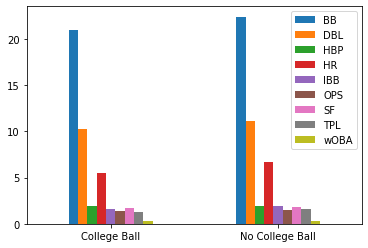

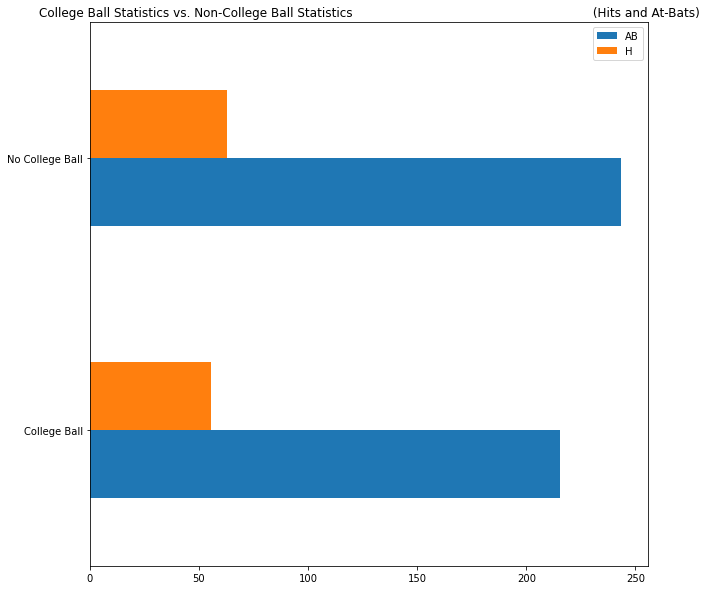

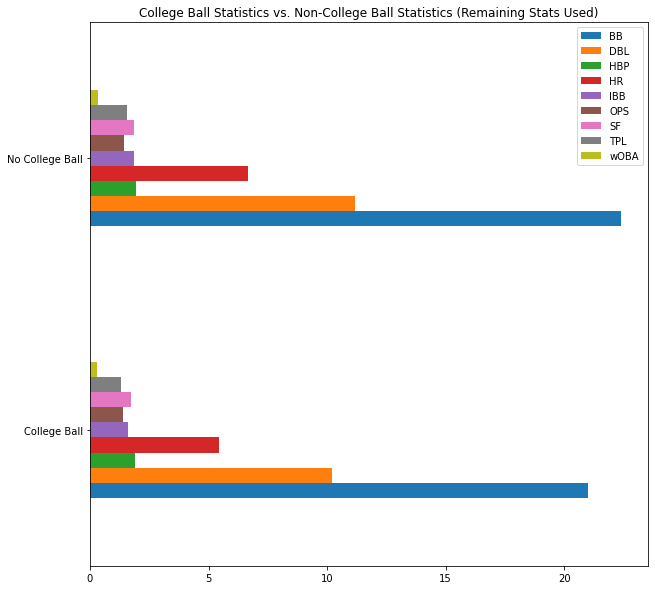

In [135]:
my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(stats))]
exclude2 = ['BB', 'DBL', 'HBP', 'HR', 'IBB', 'OPS', 'SF', 'TPL', 'wOBA']
cols = stats.loc[:, stats.columns.difference(exclude2)].plot(kind="barh", rot = 0, figsize=(10,10), \
                                                             title = "College Ball Statistics vs. Non-College Ball Statistics \
                                                             (Hits and At-Bats)")
exclude1 = ['AB', 'H']
stats.loc[:, stats.columns.difference(exclude1)].sort_values(by=['DBL', 'HBP', 'HR']).plot(kind="barh", rot = 0, figsize=(10,10)) 
plt.title("College Ball Statistics vs. Non-College Ball Statistics (Remaining Stats Used)")
plt.show()